# Explication du code

## Library imports

In [9]:
import cv2
import numpy as np #analyse d'arrays
import os # navigation de fichiers
import glob
import matplotlib.pyplot as plt # graphiques et visualisations
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter # ouvrir, manipuler et enregistrer de simages
import imageio # gifs
import torch # apprentissage automatique, requis pour detectron
from detectron2.engine import DefaultPredictor # deep learning bib developpé par facebook AI research
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from IPython.display import Image as IPImage, display # afficher multimédia dans jupyter
from detectron2.data import MetadataCatalog

## Detectron

In [10]:
# Initialize Detectron2
cfg = get_cfg() # objet de configuration detectron
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # config pré-définie
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # définition du score minimum pour la prédiction
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # URL des poids des modèles pré-entrainés
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use CUDA if available

predictor = DefaultPredictor(cfg) # création d'u objet predictor selon la configuration cfg

## Réduction de la résolution de l'image

In [11]:
# Function to drastically reduce image size
def drastically_reduce_image_size(image, scale=0.125): # réduction de 12.5% de la résolution des images pour les tests
    width = int(image.shape[1] * scale) # image.shape [height, width]
    height = int(image.shape[0] * scale)
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA) # méthode d'interpolation utilisée

## TEST

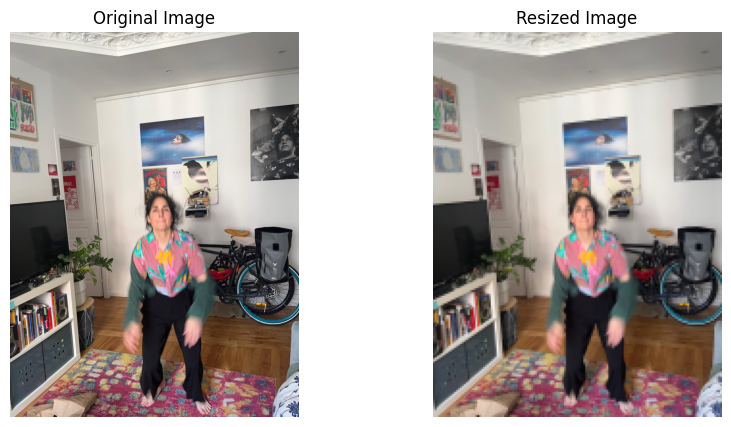

In [12]:
# Test Reduce Image Size Function
image_path = 'Desktop/GoPro_testTechnique/testNoelia/IMG-20240623-WA0000.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

# Drastically reduce image size
image_resized = drastically_reduce_image_size(image)

# Display the original and resized image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_resized)
plt.title("Resized Image")
plt.axis('off')

plt.show()

## Function pour parcourrir toutes les images dans dossier et les réduire

In [13]:
# Function to process images in the input folder
def process_images(input_folder, scale=0.125):
    # tri des images par ordre alphabétique
    # all_images : création de liste avec tous les fichiers
    # retour img pour toute img dans input folder, si png ou jpg
    all_images = sorted([img for img in os.listdir(input_folder) if img.endswith('.jpg') or img.endswith('.png')])
    # boucle sur chaque image
    for img_name in all_images:
        image_path = os.path.join(input_folder, img_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = drastically_reduce_image_size(image, scale)
        yield img_name, image_resized

## TEST d'une image

Processed IMG-20240623-WA0000.jpg: (200, 150, 3)


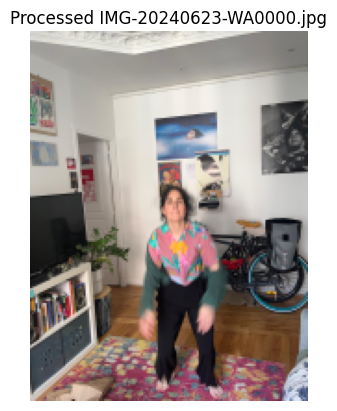

In [29]:
# Test the process_images function
input_folder = "Desktop/GoPro_testTechnique/testNoelia"
for img_name, image_resized in process_images(input_folder):
    print(f"Processed {img_name}: {image_resized.shape}")
    plt.imshow(image_resized)
    plt.title(f"Processed {img_name}")
    plt.axis('off')
    plt.show()
    break  # Show only the first image for testing

## Extraction de formes humaines des images et enregistrement

In [15]:
# Function to extract and save cropped human shapes
def save_cropped_humans(input_folder, output_folder, scale=0.125):
    os.makedirs(output_folder, exist_ok=True) # création du dossier de sortie
    for img_name, image_resized in process_images(input_folder, scale): # boucle avec réduction des images
        outputs = predictor(image_resized) # préparer output
        instances = outputs["instances"] # récupere les instances détectées
        human_masks = instances.pred_masks[instances.pred_classes == 0] # classe 0 = séléctionner les masques humaines des instances
        
        if len(human_masks) > 0: # extraction et sauvegarde des masques humaines découpées
            human_mask = human_masks[0].cpu().numpy() # convertit le premier masque humain détécté en un tableau numpy
            human_shape = image_resized * human_mask[:, :, np.newaxis] # applique le masque à l'image pour extraire la forme humaine
            human_img_path = os.path.join(output_folder, f"human_{img_name}") # chemin pour enregistrer l'image
            Image.fromarray(human_shape).save(human_img_path) #co,vertion du tableau numpy en image PIL et enregistrement

## TEST avec une image

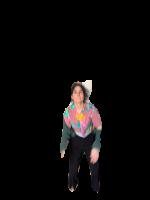

In [16]:
# Test Save Cropped Humans
output_folder_humans = "Desktop/GoPro_testTechnique/cropped_humans"
save_cropped_humans(input_folder, output_folder_humans, scale=0.125)

# Display a sample cropped human
sample_human = os.path.join(output_folder_humans, os.listdir(output_folder_humans)[0])
display(IPImage(filename=sample_human))

In [ ]:
## Extraction des backgrounds des images et enregistrement

In [17]:
# Function to extract and save cropped backgrounds
def save_cropped_backgrounds(input_folder, output_folder, scale=0.125):
    os.makedirs(output_folder, exist_ok=True)
    for img_name, image_resized in process_images(input_folder, scale):
        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]
        
        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            # np.newaxis : ransforme un tableau de forme (hauteur, largeur) en (hauteur, largeur, 1)
            # Ce changement permet à numpy de diffuser le masque sur les trois canaux de l'image.
            background_shape = image_resized * (1 - human_mask[:, :, np.newaxis]) # inversion du masque pour extraire le BG
            background_img_path = os.path.join(output_folder, f"background_{img_name}")
            Image.fromarray(background_shape.astype(np.uint8)).convert("RGB").save(background_img_path, "JPEG")

## TEST

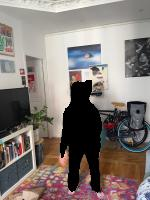

In [18]:
# Test Save Cropped Backgrounds
output_folder_backgrounds = "Desktop/GoPro_testTechnique/cropped_backgrounds"
save_cropped_backgrounds(input_folder, output_folder_backgrounds, scale=0.125)

# Display a sample cropped background
sample_background = os.path.join(output_folder_backgrounds, os.listdir(output_folder_backgrounds)[0])
display(IPImage(filename=sample_background))

In [ ]:
## Extraire, découper et colorer la silhouette humaine

In [61]:
# Function to extract, crop, and color the silhouette
def extract_and_color_silhouette(image, mask, color, opacity=0.5):
    mask = mask.astype(np.uint8) * 255  # Le masque initialement en valeurs 0 et 1 est transformé en valeurs 0 et 255, où 255 représente les pixels de l'objet d'intérêt
    silhouette = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8) # stocker masque
    cropped_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8) # stocker image découpée
    
    for c in range(3):  # For each color channel
        silhouette[:, :, c] = color[c] * (mask // 255)
        cropped_image[:, :, c] = image[:, :, c] * (mask // 255)
    
    silhouette[:, :, 3] = (mask * opacity).astype(np.uint8)  # Set alpha channel with opacity
    cropped_image[:, :, 3] = (mask * 1).astype(np.uint8)  # Set alpha channel with opacity
    
    silhouette_img = Image.fromarray(silhouette)
    cropped_img = Image.fromarray(cropped_image)
    return cropped_img, silhouette_img

## TEST avec une image

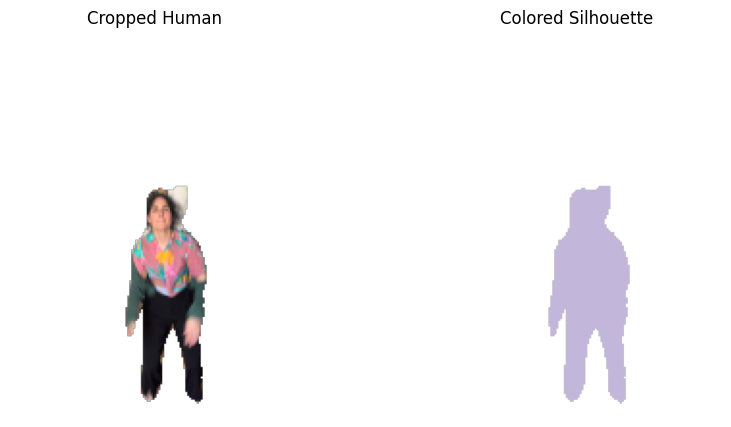

In [62]:
# Test the extract_and_color_silhouette function
for img_name, image_resized in process_images(input_folder):
    outputs = predictor(image_resized) ## CREER FONCTION PREDICT HUMAN SHAPE
    instances = outputs["instances"]
    human_masks = instances.pred_masks[instances.pred_classes == 0]  # Class 0 corresponds to 'person'
    if len(human_masks) > 0:
        human_mask = human_masks[0].cpu().numpy()
        color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
        cropped_img, colored_silhouette = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.5)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cropped_img)
        plt.title("Cropped Human")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(colored_silhouette)
        plt.title("Colored Silhouette")
        plt.axis('off')

        plt.show()
        break  # Show only the first result for testing

## Fonctions pour extraire, colorer et enregistrer les formes humaines et BGs

In [65]:
# Function to save cropped human shapes
def save_cropped_humans(input_folder, output_folder, scale=0.125):
    os.makedirs(output_folder, exist_ok=True)
    for img_name, image_resized in process_images(input_folder, scale):
        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]  # Class 0 corresponds to 'person'
        
        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
            cropped_img, _ = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.5)
            
            human_img_path = os.path.join(output_folder, f"human_{img_name}")
            cropped_img.convert("RGB").save(human_img_path, "JPEG") # TESTER ENREGISTREMENT EN PNG

## TEST avec une image

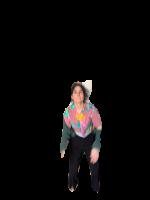

In [66]:
# Test the save_cropped_humans function
output_folder_humans = "Desktop/GoPro_testTechnique/cropped_humans"
save_cropped_humans(input_folder, output_folder_humans, scale=0.125)

# Display a sample cropped human
sample_human = os.path.join(output_folder_humans, os.listdir(output_folder_humans)[0])
display(IPImage(filename=sample_human))

In [67]:
# Function to save cropped backgrounds without human shapes
def save_cropped_backgrounds(input_folder, output_folder, scale=0.125):
    os.makedirs(output_folder, exist_ok=True)
    for img_name, image_resized in process_images(input_folder, scale):
        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]  # Class 0 corresponds to 'person'
        
        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            background_cropped = image_resized * (1 - human_mask[:, :, np.newaxis])
            
            background_img_path = os.path.join(output_folder, f"background_{img_name}")
            Image.fromarray(background_cropped.astype(np.uint8)).convert("RGB").save(background_img_path, "JPEG") # JPEG pour des fins de taille de l'image

## TEST avec une image

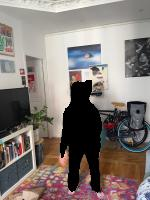

In [68]:
# Test the save_cropped_backgrounds function
output_folder_backgrounds = "Desktop/GoPro_testTechnique/cropped_backgrounds"
save_cropped_backgrounds(input_folder, output_folder_backgrounds, scale=0.125)

# Display a sample cropped background
sample_background = os.path.join(output_folder_backgrounds, os.listdir(output_folder_backgrounds)[0])
display(IPImage(filename=sample_background))

## Fonction pour 

In [69]:
# Function to create GIF of accumulated human silhouettes over evolving background
def create_gif_accumulated_humans(input_folder, output_gif_path, scale=0.125):
    os.makedirs(os.path.dirname(output_gif_path), exist_ok=True)  # Ensure output directory exists
    gif_images = []
    accumulated_silhouettes = None # stocker les silhouettes accumulées

    for img_name, image_resized in process_images(input_folder, scale): # réductiond es images et detectron
        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]  # Class 0 corresponds to 'person'

        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
            cropped_img, colored_silhouette = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.5)

            if accumulated_silhouettes is None:
                accumulated_silhouettes = Image.new("RGBA", cropped_img.size, (255, 255, 255, 0))

            # Accumulate the silhouette
            accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, colored_silhouette)

            # Combine the current frame with the accumulated silhouettes
            combined_image = Image.alpha_composite(Image.fromarray(image_resized).convert("RGBA"), accumulated_silhouettes)

            # Save the combined image for the GIF
            gif_images.append(np.array(combined_image))

    # Create and save the GIF
    imageio.mimsave(output_gif_path, gif_images, fps=10)

## TEST

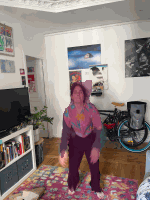

In [70]:
# Test Create GIF of Accumulated Human Silhouettes Over changing Background
output_gif_path_accumulated = "Desktop/GoPro_testTechnique/output/accumulated_humans.gif"
create_gif_accumulated_humans(input_folder, output_gif_path_accumulated, scale=0.125)

# Display GIF
display(IPImage(filename=output_gif_path_accumulated))

In [71]:
# Function to create GIF of accumulated human silhouettes with camera tracking
def create_gif_with_camera_tracking(input_folder, output_gif_path, scale=0.125):
    os.makedirs(os.path.dirname(output_gif_path), exist_ok=True)  # Ensure output directory exists
    gif_images = []
    accumulated_silhouettes = None
    previous_image_gray = None
    previous_keypoints = None
    previous_descriptors = None

    # camera tracking functions from openCV
    sift = cv2.SIFT_create() # objet SIFT pour détecter les points clés et les descripteurs
    bf = cv2.BFMatcher() # brute-force matcher pour faire correspondre les descripteurs

    for img_name, image_resized in process_images(input_folder, scale):
        # Les algorithmes comme SIFT sont conçus pour détecter des points d'intérêt 
        # basés sur les variations d'intensité dans l'image. 
        # Les variations de couleur peuvent introduire des informations supplémentaires 
        # qui ne sont pas nécessairement utiles pour détecter les caractéristiques structurales de l'image
        image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY) # image en niveaux dr gris pour la détéction de points clés

        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]

        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
            cropped_img, colored_silhouette = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.2)

            if accumulated_silhouettes is None:
                accumulated_silhouettes = Image.new("RGBA", cropped_img.size, (255, 255, 255, 0))
                previous_image_gray = image_gray
                previous_keypoints, previous_descriptors = sift.detectAndCompute(previous_image_gray, None)
                continue

            # Detect keypoints and descriptors in the current image
            keypoints, descriptors = sift.detectAndCompute(image_gray, None)

            # Match descriptors
            matches = bf.knnMatch(previous_descriptors, descriptors, k=2)
            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            # calcul de l'homographie et transformation des silhouettes accumulées
            if len(good_matches) >= 4:
                points_previous = np.float32([previous_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                points_current = np.float32([keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                H, mask = cv2.findHomography(points_current, points_previous, cv2.RANSAC, 5.0)
                accumulated_silhouettes = accumulated_silhouettes.transform(
                    cropped_img.size, Image.PERSPECTIVE, data=H.flatten()[:8], resample=Image.BILINEAR
                )

            # Accumulate the silhouette
            accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, colored_silhouette)

            # Combine the current frame with the accumulated silhouettes
            combined_image = Image.alpha_composite(Image.fromarray(image_resized).convert("RGBA"), accumulated_silhouettes)

            # Save the combined image for the GIF
            gif_images.append(np.array(combined_image))

            # Update previous image, keypoints, and descriptors
            previous_image_gray = image_gray
            previous_keypoints, previous_descriptors = keypoints, descriptors

    # Create and save the GIF
    imageio.mimsave(output_gif_path, gif_images, fps=10)

## TEST des silhouettes qui bougent selon le mouvement de la caméra

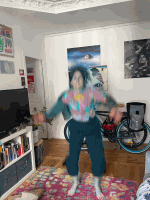

In [72]:
# Test Create GIF of Accumulated Human Silhouettes with Camera Tracking
output_gif_path_tracking = "Desktop/GoPro_testTechnique/output/tracking_humans.gif"
create_gif_with_camera_tracking(input_folder, output_gif_path_tracking, scale=0.125)

# Display GIF
display(IPImage(filename=output_gif_path_tracking))

## Création d'una image panoramique a partir de la suite de Rafale

In [47]:
# Function to create panorama from images
def create_panorama(input_folder, scale=0.125):
    image_paths = sorted([os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith('.jpg') or img.endswith('.png')])
    images = [drastically_reduce_image_size(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), scale) for img_path in image_paths]

    stitcher = cv2.Stitcher_create() # création d'un objet panorama pour assembler les images du panorama
    status, panorama = stitcher.stitch(images) # coudre les images ensemble

    if status == 0:
        panorama_image = Image.fromarray(panorama).convert("RGBA")
        return panorama_image
    else:
        print(f"Error in stitching images: {status}")
        return None

In [ ]:
## TEST

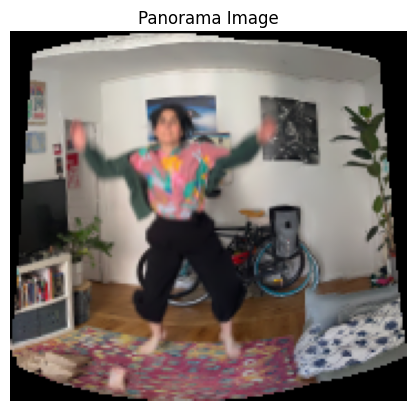

In [48]:
# Test Create Panorama
panorama_image = create_panorama(input_folder, scale=0.125)
if panorama_image:
    plt.imshow(panorama_image)
    plt.title("Panorama Image")
    plt.axis('off')
    plt.show()

In [51]:
# Function to create GIF of accumulated human silhouettes over panoramic image
def create_gif_over_panorama(input_folder, output_gif_path, scale=0.125):
    panorama_image = create_panorama(input_folder, scale)
    if not panorama_image:
        print("Panorama creation failed.")
        return
    
    accumulated_silhouettes = Image.new("RGBA", panorama_image.size, (255, 255, 255, 0))
    gif_images = []

    for img_name, image_resized in process_images(input_folder, scale):
        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]  # Class 0 corresponds to 'person'

        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
            cropped_img, colored_silhouette = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.5)

            # Ensure the colored silhouette matches the size of accumulated silhouettes
            # cette partie déforme les silhouettes, à améliorer
            colored_silhouette = colored_silhouette.resize(accumulated_silhouettes.size, resample=Image.BILINEAR)

            # Accumulate the silhouette
            accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, colored_silhouette)

            # Combine the panorama with the accumulated silhouettes
            combined_image = Image.alpha_composite(panorama_image, accumulated_silhouettes)

            # Save the combined image for the GIF
            gif_images.append(np.array(combined_image))

    # Create and save the GIF
    imageio.mimsave(output_gif_path, gif_images, fps=10)

## TEST

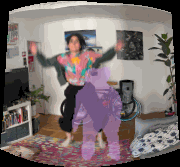

In [52]:
# Test Create GIF of Accumulated Human Silhouettes Over Panoramic Image
output_gif_path_panorama = "Desktop/GoPro_testTechnique/output/panorama_humans.gif"
create_gif_over_panorama(input_folder, output_gif_path_panorama, scale=0.125)

# Display GIF
display(IPImage(filename=output_gif_path_panorama))

In [ ]:
## BG qui bouge

In [63]:
# Function to create GIF of accumulated human silhouettes over moving background with camera tracking
def create_gif_with_moving_background(input_folder, output_gif_path, scale=0.125):
    panorama_background = None
    accumulated_silhouettes = None
    previous_image_gray = None
    previous_keypoints = None
    previous_descriptors = None

    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()

    gif_images = []

    for img_name, image_resized in process_images(input_folder, scale):
        image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]  # Class 0 corresponds to 'person'

        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
            cropped_img, colored_silhouette = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.8)

            if panorama_background is None:
                panorama_background = Image.new("RGBA", cropped_img.size, (255, 255, 255, 0))
                accumulated_silhouettes = Image.new("RGBA", cropped_img.size, (255, 255, 255, 0))
                previous_image_gray = image_gray
                previous_keypoints, previous_descriptors = sift.detectAndCompute(previous_image_gray, None)
                continue

            # Detect keypoints and descriptors in the current image
            keypoints, descriptors = sift.detectAndCompute(image_gray, None)

            # Match descriptors
            matches = bf.knnMatch(previous_descriptors, descriptors, k=2)

            # Apply ratio test
            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            # Check if there are enough good matches
            if len(good_matches) >= 4:
                # Extract location of good matches
                points_previous = np.float32([previous_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                points_current = np.float32([keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

                # Find homography
                H, mask = cv2.findHomography(points_current, points_previous, cv2.RANSAC, 5.0)

                # Warp the accumulated silhouettes to align with the current image
                accumulated_silhouettes = accumulated_silhouettes.transform(
                    panorama_background.size,
                    Image.PERSPECTIVE,
                    data=H.flatten()[:8],
                    resample=Image.BILINEAR
                )

                # Accumulate the silhouette
                accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, colored_silhouette)

                # Accumulate the background
                background_cropped = (image_resized * (1 - human_mask[:, :, np.newaxis])).astype(np.uint8)
                background_img = Image.fromarray(background_cropped).convert("RGBA")
                panorama_background = Image.alpha_composite(panorama_background, background_img)

            else:
                # Not enough matches, skip to the next image
                continue

            # Combine the panorama with the accumulated silhouettes
            combined_image = Image.alpha_composite(panorama_background, accumulated_silhouettes)

            # Save the combined image for the GIF
            gif_images.append(np.array(combined_image))

            # Update previous image, keypoints, and descriptors
            previous_image_gray = image_gray
            previous_keypoints, previous_descriptors = keypoints, descriptors

    # Create and save the GIF
    imageio.mimsave(output_gif_path, gif_images, fps=10)

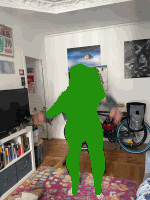

In [64]:
# Test Create GIF of Accumulated Human Silhouettes Over Moving Background with Camera Tracking
output_gif_path_moving_bg = "Desktop/GoPro_testTechnique/output/moving_background_humans.gif"
create_gif_with_moving_background(input_folder, output_gif_path_moving_bg, scale=0.125)

# Display GIF
display(IPImage(filename=output_gif_path_moving_bg))

In [73]:
# Function to extract and color the silhouette
def extract_and_color_silhouette(image, mask, color, opacity=0.5):
    mask = mask.astype(np.uint8) * 255  # Convert mask to binary (0 or 255)
    silhouette = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
    colored_mask = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
    
    # Apply the mask to the original image and color the silhouette
    for c in range(3):  # For each color channel
        colored_mask[:, :, c] = color[c] * (mask // 255)
        silhouette[:, :, c] = image[:, :, c] * (mask // 255)
    
    colored_mask[:, :, 3] = (mask * opacity).astype(np.uint8)  # Set alpha channel with opacity
    silhouette[:, :, 3] = 255  # Set alpha channel to fully opaque
    
    colored_mask_img = Image.fromarray(colored_mask)
    silhouette_img = Image.fromarray(silhouette)
    return colored_mask_img, silhouette_img

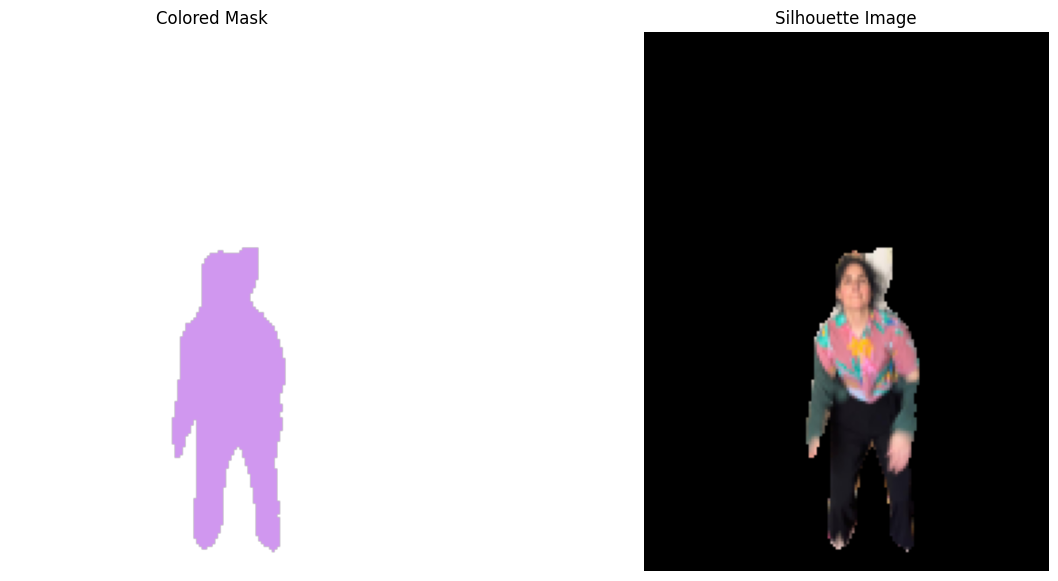

In [74]:
# Load an example image and reduce its size
image_path = 'Desktop/GoPro_testTechnique/testNoelia/IMG-20240623-WA0000.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = drastically_reduce_image_size(image)

# Predict mask
outputs = predictor(image_resized)
instances = outputs["instances"]
human_masks = instances.pred_masks[instances.pred_classes == 0]  # Class 0 corresponds to 'person'

if len(human_masks) > 0:
    human_mask = human_masks[0].cpu().numpy()
    color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
    colored_mask_img, silhouette_img = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.5)
    
    # Display the colored mask and silhouette
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(colored_mask_img)
    plt.title("Colored Mask")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(silhouette_img)
    plt.title("Silhouette Image")
    plt.axis('off')

    plt.show()
else:
    print("No human detected in the image.")

In [75]:
def create_gif_with_moving_background(input_folder, output_gif_path, scale=0.125):
    panorama_background = None
    accumulated_silhouettes = None
    previous_image_gray = None
    previous_keypoints = None
    previous_descriptors = None

    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()

    gif_images = []

    for img_name, image_resized in process_images(input_folder, scale):
        image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]  # Class 0 corresponds to 'person'

        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
            colored_mask_img, silhouette_img = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.5)

            if panorama_background is None:
                panorama_background = Image.new("RGBA", silhouette_img.size, (255, 255, 255, 0))
                accumulated_silhouettes = Image.new("RGBA", silhouette_img.size, (255, 255, 255, 0))
                previous_image_gray = image_gray
                previous_keypoints, previous_descriptors = sift.detectAndCompute(previous_image_gray, None)
                continue

            # Detect keypoints and descriptors in the current image
            keypoints, descriptors = sift.detectAndCompute(image_gray, None)

            # Match descriptors
            matches = bf.knnMatch(previous_descriptors, descriptors, k=2)

            # Apply ratio test
            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            # Check if there are enough good matches
            if len(good_matches) >= 4:
                # Extract location of good matches
                points_previous = np.float32([previous_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                points_current = np.float32([keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

                # Find homography
                H, mask = cv2.findHomography(points_current, points_previous, cv2.RANSAC, 5.0)

                # Warp the accumulated silhouettes to align with the current image
                accumulated_silhouettes = accumulated_silhouettes.transform(
                    panorama_background.size,
                    Image.PERSPECTIVE,
                    data=H.flatten()[:8],
                    resample=Image.BILINEAR
                )

                # Accumulate the silhouette
                accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, colored_mask_img)
                accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, silhouette_img)

                # Accumulate the background
                background_cropped = (image_resized * (1 - human_mask[:, :, np.newaxis])).astype(np.uint8)
                background_img = Image.fromarray(background_cropped).convert("RGBA")
                panorama_background = Image.alpha_composite(panorama_background, background_img)

            else:
                # Not enough matches, skip to the next image
                continue

            # Combine the panorama with the accumulated silhouettes
            combined_image = Image.alpha_composite(panorama_background, accumulated_silhouettes)

            # Save the combined image for the GIF
            gif_images.append(np.array(combined_image))

            # Update previous image, keypoints, and descriptors
            previous_image_gray = image_gray
            previous_keypoints, previous_descriptors = keypoints, descriptors

    # Create and save the GIF
    imageio.mimsave(output_gif_path, gif_images, fps=10)

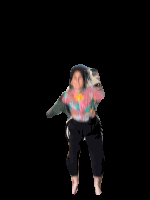

In [76]:
# Test Create GIF of Accumulated Human Silhouettes Over Moving Background with Camera Tracking
output_gif_path_moving_bg = "Desktop/GoPro_testTechnique/output/moving_background_humans.gif"
create_gif_with_moving_background(input_folder, output_gif_path_moving_bg, scale=0.125)

# Display GIF
display(IPImage(filename=output_gif_path_moving_bg))

In [88]:
# Function to create GIF of accumulated human silhouettes over evolving background
def create_gif_accumulated_humans(input_folder, output_gif_path, scale=0.125):
    gif_images = []
    accumulated_silhouettes = None
    
    for img_name, image_resized in process_images(input_folder, scale):
        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]
        
        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
            cropped_img, colored_silhouette = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.5)
            
            if accumulated_silhouettes is None:
                accumulated_silhouettes = Image.new("RGBA", cropped_img.size, (255, 255, 255, 0))
            
            accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, colored_silhouette)
            accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, cropped_img)

            combined_image = Image.alpha_composite(Image.fromarray(image_resized).convert("RGBA"), accumulated_silhouettes)
            gif_images.append(np.array(combined_image))
        else:
            print("No human detected in the image.")
    
    imageio.mimsave(output_gif_path, gif_images, fps=10)

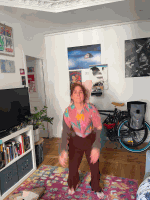

In [89]:
# Test Create GIF of Accumulated Human Silhouettes Over Evolving Background
output_gif_path_accumulated = "Desktop/GoPro_testTechnique/output/accumulated_humans.gif"
create_gif_accumulated_humans(input_folder, output_gif_path_accumulated, scale=0.125)

# Display GIF
display(IPImage(filename=output_gif_path_accumulated))

In [90]:
# Function to create GIF with camera tracking
def create_gif_with_camera_tracking(input_folder, output_gif_path, scale=0.125):
    gif_images = []
    accumulated_silhouettes = None
    previous_image_gray = None
    previous_keypoints = None
    previous_descriptors = None

    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()

    for img_name, image_resized in process_images(input_folder, scale):
        image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

        if accumulated_silhouettes is None:
            accumulated_silhouettes = Image.new("RGBA", Image.fromarray(image_resized).size, (255, 255, 255, 0))
            previous_image_gray = image_gray
            previous_keypoints, previous_descriptors = sift.detectAndCompute(previous_image_gray, None)
            continue

        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]

        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
            cropped_img, colored_silhouette = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.5)

            keypoints, descriptors = sift.detectAndCompute(image_gray, None)
            matches = bf.knnMatch(previous_descriptors, descriptors, k=2)

            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            if len(good_matches) >= 4:
                points_previous = np.float32([previous_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                points_current = np.float32([keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                H, mask = cv2.findHomography(points_current, points_previous, cv2.RANSAC, 5.0)

                accumulated_silhouettes = accumulated_silhouettes.transform(
                    Image.fromarray(image_resized).size,
                    Image.PERSPECTIVE,
                    data=H.flatten()[:8],
                    resample=Image.BILINEAR
                )

            accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, colored_silhouette)
            accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, cropped_img)
            
            combined_image = Image.alpha_composite(Image.fromarray(image_resized).convert("RGBA"), accumulated_silhouettes)
            gif_images.append(np.array(combined_image))
            
            previous_image_gray = image_gray
            previous_keypoints, previous_descriptors = keypoints, descriptors
        else:
            print("No human detected in the image.")

    imageio.mimsave(output_gif_path, gif_images, fps=10)

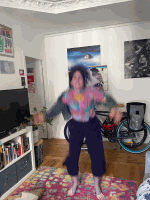

In [91]:
# Test Create GIF with Camera Tracking
output_gif_path_camera_tracking = "Desktop/GoPro_testTechnique/output/camera_tracking_humans.gif"
create_gif_with_camera_tracking(input_folder, output_gif_path_camera_tracking, scale=0.125)

# Display GIF
display(IPImage(filename=output_gif_path_camera_tracking))

In [98]:
# Function to create a panoramic image
def create_panorama(input_folder, scale=0.125):
    images = []
    for img_name, image_resized in process_images(input_folder, scale):
        images.append(image_resized)
    stitcher = cv2.Stitcher_create()
    status, panorama = stitcher.stitch(images)
    if status != cv2.Stitcher_OK:
        print("Error during stitching")
        return None
    return panorama

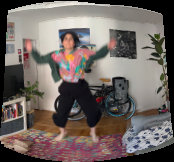

In [99]:
# Test Create Panorama
panorama_image = create_panorama(input_folder, scale=0.125)
if panorama_image is not None:
    panorama_image_pil = Image.fromarray(panorama_image).convert("RGBA")
    display(panorama_image_pil)
else:
    print("Panorama creation failed")

In [100]:
# Function to create GIF of accumulated human silhouettes over panoramic image
def create_gif_over_panorama(input_folder, output_gif_path, scale=0.125):
    gif_images = []
    accumulated_silhouettes = None

    panorama_image = create_panorama(input_folder, scale)
    panorama_image_pil = Image.fromarray(panorama_image).convert("RGBA")
    display(panorama_image_pil)

    for img_name, image_resized in process_images(input_folder, scale):
        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]

        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
            cropped_img, colored_silhouette = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.5)
            
            if accumulated_silhouettes is None:
                accumulated_silhouettes = Image.new("RGBA", panorama_image_pil.size, (255, 255, 255, 0))

            # Resize the silhouettes to match the panorama size
            colored_silhouette = colored_silhouette.resize(panorama_image_pil.size, resample=Image.BILINEAR)
            cropped_img = cropped_img.resize(panorama_image_pil.size, resample=Image.BILINEAR)

            accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, colored_silhouette)
            accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, cropped_img)

            combined_image = Image.alpha_composite(panorama_image_pil, accumulated_silhouettes)
            gif_images.append(np.array(combined_image))
        else:
            print("No human detected in the image.")
    
    imageio.mimsave(output_gif_path, gif_images, fps=10)

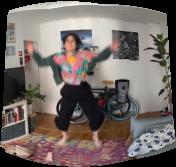

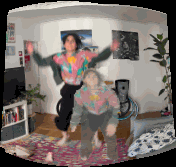

In [101]:
# Test Create GIF of Accumulated Human Silhouettes Over Panoramic Image
output_gif_path_panorama = "Desktop/GoPro_testTechnique/output/panorama_humans.gif"
create_gif_over_panorama(input_folder, output_gif_path_panorama, scale=0.125)

# Display GIF
display(IPImage(filename=output_gif_path_panorama))

In [96]:
# Function to create GIF with moving background and camera tracking
def create_gif_with_moving_background(input_folder, output_gif_path, scale=0.125):
    gif_images = []
    accumulated_silhouettes = None
    previous_image_gray = None
    previous_keypoints = None
    previous_descriptors = None

    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()
    panorama_background = None

    for img_name, image_resized in process_images(input_folder, scale):
        image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

        if panorama_background is None:
            panorama_background = Image.fromarray(image_resized).convert("RGBA")
            accumulated_silhouettes = Image.new("RGBA", panorama_background.size, (255, 255, 255, 0))
            previous_image_gray = image_gray
            previous_keypoints, previous_descriptors = sift.detectAndCompute(previous_image_gray, None)
            continue

        outputs = predictor(image_resized)
        instances = outputs["instances"]
        human_masks = instances.pred_masks[instances.pred_classes == 0]

        if len(human_masks) > 0:
            human_mask = human_masks[0].cpu().numpy()
            color = (int(255 * np.random.random()), int(255 * np.random.random()), int(255 * np.random.random()))
            cropped_img, colored_silhouette = extract_and_color_silhouette(image_resized, human_mask, color, opacity=0.5)

            keypoints, descriptors = sift.detectAndCompute(image_gray, None)
            matches = bf.knnMatch(previous_descriptors, descriptors, k=2)

            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            if len(good_matches) >= 4:
                points_previous = np.float32([previous_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                points_current = np.float32([keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                H, mask = cv2.findHomography(points_current, points_previous, cv2.RANSAC, 5.0)

                accumulated_silhouettes = accumulated_silhouettes.transform(
                    Image.fromarray(image_resized).size,
                    Image.PERSPECTIVE,
                    data=H.flatten()[:8],
                    resample=Image.BILINEAR
                )

                panorama_background = panorama_background.transform(
                    Image.fromarray(image_resized).size,
                    Image.PERSPECTIVE,
                    data=H.flatten()[:8],
                    resample=Image.BILINEAR
                )

            accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, colored_silhouette)
            accumulated_silhouettes = Image.alpha_composite(accumulated_silhouettes, cropped_img)
            
            combined_image = Image.alpha_composite(panorama_background, accumulated_silhouettes)
            gif_images.append(np.array(combined_image))
            
            previous_image_gray = image_gray
            previous_keypoints, previous_descriptors = keypoints, descriptors
        else:
            print("No human detected in the image.")

    imageio.mimsave(output_gif_path, gif_images, fps=10)

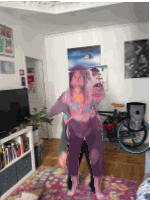

In [97]:
# Test Create GIF with Moving Background and Camera Tracking
output_gif_path_moving_bg = "Desktop/GoPro_testTechnique/output/moving_background_humans.gif"
create_gif_with_moving_background(input_folder, output_gif_path_moving_bg, scale=0.125)

# Display GIF
display(IPImage(filename=output_gif_path_moving_bg))